# TavilySearchResults
https://github.com/teddylee777/langchain-kr/blob/6f76b9eaede6ce115334ad40294dc264189b30e0/17-LangGraph/04-langgraph-search-or-retrieve.ipynb#L56

In [7]:
import os
import pprint
from dotenv import load_dotenv
## langsmith
from langsmith import Client
from langchain_teddynote import logging
## OpenAI
from langchain_openai import ChatOpenAI
from langchain.schema import ChatMessage, AIMessage, HumanMessage, SystemMessage
from langchain.embeddings.openai import OpenAIEmbeddings
## ChromaDB
import chromadb
from langchain.vectorstores import Chroma
## History
from operator import itemgetter
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.chat_message_histories import ChatMessageHistory, StreamlitChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
## LangGraph
from typing import TypedDict
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import GraphRecursionError
from langchain_community.tools.tavily_search import TavilySearchResults
## Google Search
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_core.tools import Tool
## gradio
import gradio as gr

In [8]:
store = {}

# 세션 ID를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store:  # 세션 ID가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환
    
##############################################################################################################
################################################Retriever#####################################################
##############################################################################################################
class MultiCollectionRetriever:
    def __init__(self, client, collection_names, embedding_function, search_kwargs={"k": 2}):
        self.collections = [
            Chroma(client=client, collection_name=name, embedding_function=embedding_function)
            for name in collection_names
        ]
        self.search_kwargs = search_kwargs

    def retrieve(self, query):
        results = []
        for collection in self.collections:
            # 각 컬렉션에서 유사도 검색 수행
            documents_with_scores = collection.similarity_search_with_score(query, **self.search_kwargs)
            results.extend(documents_with_scores)
        
        # 유사도 점수를 기준으로 결과 정렬 (score가 높을수록 유사도가 높음)
        results.sort(key=lambda x: x[1], reverse=False)

        documents = [(doc, score) for doc, score in results]
        return documents

# 사용 예시
client = chromadb.PersistentClient('../juso-chat-bot-v0.1/chroma/')
collection_names = ["csv_files_openai_3072", "49_files_openai_3072"]
embedding = OpenAIEmbeddings(model='text-embedding-3-large') 
multi_retriever = MultiCollectionRetriever(client, collection_names, embedding)

##############################################################################################################
################################################GraphState####################################################
##############################################################################################################
# GraphState 상태를 저장하는 용도
class GraphState(TypedDict):
    question: str  # 질문
    context: str  # 문서의 검색 결과
    answer: str  # llm이 생성한 답변
    relevance: str  # 답변의 문서에 대한 관련성 (groundness check)
    
##############################################################################################################
################################################vector Retriever##############################################
##############################################################################################################
def retrieve_document(state: GraphState) -> GraphState:
    # Question 에 대한 문서 검색을 retriever 로 수행합니다.
    retrieved_docs = multi_retriever.retrieve(state["question"])
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs[:2])

##############################################################################################################
################################################Groundness Checker ###########################################
##############################################################################################################
chat = ChatOpenAI(model="gpt-4o", api_key=openai_api_key)

def relevance_message(context, question):
    messages = [
        SystemMessage(content="""
            너는 Query와 Document를 비교해서 ['grounded', 'notGrounded', 'notSure'] 셋 중 하나의 라벨을 출력하는 모델이야.

            'grounded': Compare the Query and the Document. If the Document includes content that can be used to generate an answer to the Query, output the label 'grounded'.
            'notGrounded': Compare the Query and the Document. If the Document not includes content that can be used to generate an answer to the Query, output the label 'notGrounded'.
            'notSure': Compare the Query and the Document. If you cannot determine whether the Document includes content that can be used to generate an answer to the Query, output the label .notSure'.
            
            너의 출력은 반드시 'grounded', 'notGrounded', 'notSure' 중 하나여야 해. 띄어쓰기나 대소문자 구분 등 다른 형식이나 추가적인 설명 없이 오직 하나의 라벨만 출력해줘.
        """),
        HumanMessage(content=f"""
            [Document]
            {context}

            [Query]
            {question}
        """),
    ]
    return messages

def relevance_check(state: GraphState) -> GraphState:
    messages = relevance_message(state["context"], state["question"])
    response = chat.invoke(messages)
    return GraphState(
        relevance=response.content,
        context=state["context"],
        answer=state["answer"],
        question=state["question"],
    )

def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "grounded":
        return "grounded"
    elif state["relevance"] == "notGrounded":
        return "notGrounded"
    elif state["relevance"] == "notSure":
        return "notSure"
    
##############################################################################################################
################################################# Rewriter ###################################################
##############################################################################################################  
    
def rewrite(state):
    question = state["question"]
    answer = state["answer"]
    context = state["context"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a professional prompt rewriter. Your task is to generate the question in order to get additional information that is now shown in the context."
                "Your generated question will be searched on the web to find relevant information.",
            ),
            (
                "human",
                "Rewrite the question to get additional information to get the answer."
                "\n\nHere is the initial question:\n ------- \n{question}\n ------- \n"
                "\n\nHere is the initial context:\n ------- \n{context}\n ------- \n"
                "\n\nHere is the initial answer to the question:\n ------- \n{answer}\n ------- \n"
                "\n\nFormulate an improved question in Korean:",
            ),
        ]
    )

    # Question rewriting model
    model = ChatOpenAI(temperature=0, model="gpt-4o")

    chain = prompt | model | StrOutputParser()
    response = chain.invoke(
        {"question": question, "answer": answer, "context": context}
    )
    return GraphState(question=response)

    
##############################################################################################################
################################################Search on Web ################################################
##############################################################################################################  
    
def search_tool(query):
    search = GoogleSearchAPIWrapper()
    return search.results(query, 1)

tool = Tool(
    name="Google Search Snippets",
    description="Search Google for recent results.",
    func=search_tool,
)

def search_on_web(state: GraphState) -> GraphState:
    result = tool.run(state["question"])
    return GraphState(
        context=result,
    )
    
def search_on_web(state: GraphState) -> GraphState:
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    search_tool = TavilySearchResults(max_results=5)
    search_result = search_tool.invoke({"query": state["question"]})

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(
        context=search_result,
    )
    

In [ ]:
def llm_answer(state: GraphState) -> GraphState:
    
    # 프롬프트를 생성합니다.
    prompt = PromptTemplate.from_template(
        """
                너는 Context의 정보를 반드시 활용해서 답변을 생성하는 챗봇이야. 
                이때, 답변은 Context에 정보가 있을 수도 있고, 없을 수도 있어. 
                Context의 정보로 답변을 생성할 수 있는 경우 해당 정보를 활용하고, 만약 Context의 정보로 답변을 유추조차 할 수 없는 경우, Context를 참고하지 말고 그냥 너가 생각한 답변을 생성해줘.
                주소와 관련된 질문인 경우 최대한 Context의 답변을 기반을 참고해주고, 그렇지 않은 경우 그냥 너의 지식을 활용해줘.
                답변에는 Context라는 단어를 사용하지 말아줘.
                
                답변의 끝에는 '출처' 혹은 '자세한 정보'를 기입해줘. 출처와 자세한 정보에 대한 내용은 다음과 같아. 
                
                '출처'는 Context의 'context'에 metadata의 'source'에 파일경로로 기입되어 있어. pdf, csv, md 등의 파일 이름으로만 출처를 기입해주면 돼.
                만약 여러개의 출처가 기입되어 있는 경우 모두 알려주고, 중복되는 경우 하나만 기입해줘.
                이때 파일명의 확장자(pdf, csv, md 등)는 기입하지 않아도 돼.
                        
                '자세한 정보'는 Context의 [0]의 'link'에 해당하는 url이야. 반드시 'link'가 해당할 때만 해당 url을 기입하고, 너가 새로운 url을 추가하면 안돼.
                
                만약, 답변을 Context를 기반으로 생성하지 않는다면, 문장 끝에 '문서를 참고하지 않고 생성한 답변입니다.' 라고 기입해줘.

                #Previous Chat History:
                {chat_history}

                #Question: 
                {question} 

                #Context: 
                {context} 

                #Answer:
                
            """
                )

    llm = ChatOpenAI(model_name="gpt-4o", temperature=0)
    
    # 프롬프트, 모델, 출력 파서를 체이닝합니다.
    chain = prompt | llm | StrOutputParser()

    # 대화를 기록하는 RAG 체인 생성
    rag_with_history = RunnableWithMessageHistory(
        chain,
        get_session_history,  # 세션 기록을 가져오는 함수
        input_messages_key="question",  # 사용자의 질문이 템플릿 변수에 들어갈 key
        history_messages_key="chat_history",  # 기록 메시지의 키
    )
    
    # 상태에서 질문과 대화 기록을 가져옵니다.
    input_data = {
        'question': state["question"],
        'chat_history': itemgetter("chat_history"),
        'context': state["context"]
    }

    response = rag_with_history.invoke(input_data, config={"configurable": {"session_id": "rag123"}})
    
    return GraphState(
        answer=response,
        context=state["context"],
        question=state["question"],
    )

# Google Search API

In [1]:
import os
import pprint
from dotenv import load_dotenv
## langsmith
from langsmith import Client
from langchain_teddynote import logging
## OpenAI
from langchain_openai import ChatOpenAI
from langchain.schema import ChatMessage, AIMessage, HumanMessage, SystemMessage
from langchain.embeddings.openai import OpenAIEmbeddings
## ChromaDB
import chromadb
from langchain.vectorstores import Chroma
## History
from operator import itemgetter
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.chat_message_histories import ChatMessageHistory, StreamlitChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
## LangGraph
from typing import TypedDict
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import GraphRecursionError
from langchain_community.tools.tavily_search import TavilySearchResults
## Google Search
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_core.tools import Tool
## gradio
import gradio as gr

/Users/jeongyunl/opt/anaconda3/envs/juso-chatbot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# .env 파일 활성화 & API KEY 설정
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')

logging.langsmith("240731") 

LangSmith 추적을 시작합니다.
[프로젝트명]
240731


In [3]:
store = {}

# 세션 ID를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store:  # 세션 ID가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환
    
##############################################################################################################
################################################Retriever#####################################################
##############################################################################################################
class MultiCollectionRetriever:
    def __init__(self, client, collection_names, embedding_function, search_kwargs={"k": 2}):
        self.collections = [
            Chroma(client=client, collection_name=name, embedding_function=embedding_function)
            for name in collection_names
        ]
        self.search_kwargs = search_kwargs

    def retrieve(self, query):
        results = []
        for collection in self.collections:
            # 각 컬렉션에서 유사도 검색 수행
            documents_with_scores = collection.similarity_search_with_score(query, **self.search_kwargs)
            results.extend(documents_with_scores)
        
        # 유사도 점수를 기준으로 결과 정렬 (score가 높을수록 유사도가 높음)
        results.sort(key=lambda x: x[1], reverse=False)

        documents = [(doc, score) for doc, score in results]
        print(documents)
        return documents

# 사용 예시
client = chromadb.PersistentClient('../juso-chat-bot-v0.1/chroma/')
collection_names = ["csv_files_openai_3072", "49_files_openai_3072"]
embedding = OpenAIEmbeddings(model='text-embedding-3-large') 
multi_retriever = MultiCollectionRetriever(client, collection_names, embedding)

##############################################################################################################
################################################GraphState####################################################
##############################################################################################################
# GraphState 상태를 저장하는 용도
class GraphState(TypedDict):
    question: str  # 질문
    context: str  # 문서의 검색 결과
    answer: str  # llm이 생성한 답변
    relevance: str  # 답변의 문서에 대한 관련성 (groundness check)
    
##############################################################################################################
################################################vector Retriever##############################################
##############################################################################################################
def retrieve_document(state: GraphState) -> GraphState:
    # Question 에 대한 문서 검색을 retriever 로 수행합니다.
    retrieved_docs = multi_retriever.retrieve(state["question"])
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs[:2])

##############################################################################################################
################################################Groundness Checker ###########################################
##############################################################################################################
chat = ChatOpenAI(model="gpt-4o", api_key=openai_api_key)

def relevance_message(context, question):
    messages = [
        SystemMessage(content="""
            너는 Query와 Document를 비교해서 ['grounded', 'notGrounded', 'notSure'] 셋 중 하나의 라벨을 출력하는 모델이야.

            'grounded': Compare the Query and the Document. If the Document includes content that can be used to generate an answer to the Query, output the label 'grounded'.
            'notGrounded': Compare the Query and the Document. If the Document not includes content that can be used to generate an answer to the Query, output the label 'notGrounded'.
            'notSure': Compare the Query and the Document. If you cannot determine whether the Document includes content that can be used to generate an answer to the Query, output the label .notSure'.
            
            특히 '도로명주소법'에 대해서 물어봤는데, '도로명주소법 시행령' 문서의 답변을 가져왔다거나, '도로명주소법 시행령'에 대해서 물어봤는데, '도로명주소법 시행규칙'에 대해서 답변했다면 이는 전부 notGraounded에 해당한다는 점을 유의해줘.
            
            너의 출력은 반드시 'grounded', 'notGrounded', 'notSure' 중 하나여야 해. 띄어쓰기나 대소문자 구분 등 다른 형식이나 추가적인 설명 없이 오직 하나의 라벨만 출력해줘.
        """),
        HumanMessage(content=f"""
            [Document]
            {context}

            [Query]
            {question}
        """),
    ]
    return messages

def relevance_check(state: GraphState) -> GraphState:
    messages = relevance_message(state["context"], state["question"])
    response = chat.invoke(messages)
    return GraphState(
        relevance=response.content,
        context=state["context"],
        answer=state["answer"],
        question=state["question"],
    )

def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "grounded":
        return "grounded"
    elif state["relevance"] == "notGrounded":
        return "notGrounded"
    elif state["relevance"] == "notSure":
        return "notSure"
    
##############################################################################################################
################################################# Rewriter ###################################################
##############################################################################################################  
    
def rewrite(state):
    question = state["question"]
    answer = state["answer"]
    context = state["context"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a professional prompt rewriter. Your task is to generate the question in order to get additional information that is now shown in the context."
                "Your generated question will be searched on the web to find relevant information.",
            ),
            (
                "human",
                "Rewrite the question to get additional information to get the answer."
                "\n\nHere is the initial question:\n ------- \n{question}\n ------- \n"
                "\n\nHere is the initial context:\n ------- \n{context}\n ------- \n"
                "\n\nHere is the initial answer to the question:\n ------- \n{answer}\n ------- \n"
                "\n\nFormulate an improved question in Korean:",
            ),
        ]
    )

    # Question rewriting model
    model = ChatOpenAI(temperature=0, model="gpt-4o")

    chain = prompt | model | StrOutputParser()
    response = chain.invoke(
        {"question": question, "answer": answer, "context": context}
    )
    return GraphState(question=response)

    
##############################################################################################################
################################################Search on Web ################################################
##############################################################################################################  
    
def search_tool(query):
    search = GoogleSearchAPIWrapper()
    return search.results(query, 1)

tool = Tool(
    name="Google Search Snippets",
    description="Search Google for recent results.",
    func=search_tool,
)

def search_on_web(state: GraphState) -> GraphState:
    result = tool.run(state["question"])
    return GraphState(
        context=result,
    )
    

/Users/jeongyunl/opt/anaconda3/envs/juso-chatbot/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [4]:
# ##############################################################################################################
# ################################################LLM Answer Maker##############################################
# ##############################################################################################################


# def llm_answer(state: GraphState) -> GraphState:
    
#     # 프롬프트를 생성합니다.
#     prompt = PromptTemplate.from_template(
#         """
#                 너는 Context의 정보를 반드시 활용해서 답변을 생성하는 챗봇이야. 
#                 이때, 답변은 Context에 정보가 있을 수도 있고, 없을 수도 있어. 
#                 Context의 정보로 답변을 생성할 수 있는 경우 해당 정보를 활용하고, 만약 Context의 정보로 답변을 유추조차 할 수 없는 경우, Context를 참고하지 말고 그냥 너가 생각한 답변을 생성해줘.
#                 주소와 관련된 질문인 경우 최대한 Context의 답변을 기반을 참고해주고, 그렇지 않은 경우 그냥 너의 지식을 활용해줘.
#                 답변에는 Context라는 단어를 사용하지 말아줘.
                
#                 답변의 끝에는 '출처' 혹은 '자세한 정보'를 기입해줘. 출처와 자세한 정보에 대한 내용은 다음과 같아. 
                
#                 '출처'는 Context의 'context'에 metadata의 'source'에 파일경로로 기입되어 있어. pdf, csv, md 등의 파일 이름으로만 출처를 기입해주면 돼.
#                 만약 여러개의 출처가 기입되어 있는 경우 모두 알려주고, 중복되는 경우 하나만 기입해줘.
#                 이때 파일명의 확장자(pdf, csv, md 등)는 기입하지 않아도 돼.
                        
#                 '자세한 정보'는 Context의 [0]의 'link'에 해당하는 url이야. 
                
#                 만약, 답변을 Context를 기반으로 생성하지 않는다면, 문장 끝에 '문서를 참고하지 않고 생성한 답변입니다.' 라고 기입해줘.

#                 #Previous Chat History:
#                 {chat_history}

#                 #Question: 
#                 {question} 

#                 #Context: 
#                 {context} 

#                 #Answer:
                
#             """
#                 )


#     llm = ChatOpenAI(model_name="gpt-4o", temperature=0)
    
#     context = state["context"]

#     chain = (
#         {
#             # "context": lambda inputs: multi_retriever.retrieve(itemgetter("question")(inputs)),
#             "context": context,
#             "question": itemgetter("question"),
#             "chat_history": itemgetter("chat_history"),
#         }
#         | prompt
#         | llm
#         | StrOutputParser()
#     )

#     # 대화를 기록하는 RAG 체인 생성
#     rag_with_history = RunnableWithMessageHistory(
#         chain,
#         get_session_history,  # 세션 기록을 가져오는 함수
#         input_messages_key="question",  # 사용자의 질문이 템플릿 변수에 들어갈 key
#         history_messages_key="chat_history",  # 기록 메시지의 키
#     )
    
    
#     response = rag_with_history.invoke({'question': state["question"]}, config={"configurable": {"session_id": "rag123"}})
#     print(state["context"])
#     return GraphState(
#         answer=response,
#         context=state["context"],
#         question=state["question"],
#     )

In [5]:
def llm_answer(state: GraphState) -> GraphState:
    
    # 프롬프트를 생성합니다.
    prompt = PromptTemplate.from_template(
        """
                너는 Context의 정보를 반드시 활용해서 답변을 생성하는 챗봇이야. 
                이때, 답변은 Context에 정보가 있을 수도 있고, 없을 수도 있어. 
                Context의 정보로 답변을 생성할 수 있는 경우 해당 정보를 활용하고, 만약 Context의 정보로 답변을 유추조차 할 수 없는 경우, Context를 참고하지 말고 그냥 너가 생각한 답변을 생성해줘.
                주소와 관련된 질문인 경우 최대한 Context의 답변을 기반을 참고해주고, 그렇지 않은 경우 그냥 너의 지식을 활용해줘.
                답변에는 Context라는 단어를 사용하지 말아줘.
                
                답변의 끝에는 '출처' 혹은 '자세한 정보'를 기입해줘. 출처와 자세한 정보에 대한 내용은 다음과 같아. 
                
                '출처'는 Context의 'context'에 metadata의 'source'에 파일경로로 기입되어 있어. pdf, csv, md 등의 파일 이름으로만 출처를 기입해주면 돼.
                만약 여러개의 출처가 기입되어 있는 경우 모두 알려주고, 중복되는 경우 하나만 기입해줘.
                이때 파일명의 확장자(pdf, csv, md 등)는 기입하지 않아도 돼.
                        
                '자세한 정보'는 Context의 [0]의 'link'에 해당하는 url이야. 반드시 'link'가 해당할 때만 해당 url을 기입하고, 너가 새로운 url을 추가하면 안돼.
                
                만약, 답변을 Context를 기반으로 생성하지 않는다면, 문장 끝에 '문서를 참고하지 않고 생성한 답변입니다.' 라고 기입해줘.

                #Previous Chat History:
                {chat_history}

                #Question: 
                {question} 

                #Context: 
                {context} 

                #Answer:
                
            """
                )

    llm = ChatOpenAI(model_name="gpt-4o", temperature=0)
    
    # 프롬프트, 모델, 출력 파서를 체이닝합니다.
    chain = prompt | llm | StrOutputParser()

    # 대화를 기록하는 RAG 체인 생성
    rag_with_history = RunnableWithMessageHistory(
        chain,
        get_session_history,  # 세션 기록을 가져오는 함수
        input_messages_key="question",  # 사용자의 질문이 템플릿 변수에 들어갈 key
        history_messages_key="chat_history",  # 기록 메시지의 키
    )
    
    # 상태에서 질문과 대화 기록을 가져옵니다.
    input_data = {
        'question': state["question"],
        'chat_history': itemgetter("chat_history"),
        'context': state["context"]
    }

    response = rag_with_history.invoke(input_data, config={"configurable": {"session_id": "rag123"}})
    
    return GraphState(
        answer=response,
        context=state["context"],
        question=state["question"],
    )

In [6]:
# ##############################################################################################################
# ################################################Setting Graph Relations#######################################
# ##############################################################################################################

# workflow = StateGraph(GraphState)

# # 노드들을 정의합니다.
# workflow.add_node("retrieve", retrieve_document)  # 답변을 검색해오는 노드를 추가합니다.
# workflow.add_node("llm_answer", llm_answer)  # 답변을 생성하는 노드를 추가합니다.
# workflow.add_node("relevance_check", relevance_check)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.
# workflow.add_node("rewrite", rewrite)  # 질문을 재작성하는 노드를 추가합니다.
# workflow.add_node("search_on_web", search_on_web)  # 웹 검색 노드를 추가합니다.

# workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 답변
# workflow.add_edge("rewrite", "search_on_web")  # 재작성 -> 관련성 체크
# workflow.add_edge("search_on_web", "relevance_check")  # 웹 검색 -> 답변

# # 조건부 엣지를 추가합니다.
# workflow.add_conditional_edges(
#     "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
#     is_relevant,
#     {
#         "grounded": "llm_answer",  # 관련성이 있으면 종료합니다.
#         "notGrounded": "rewrite",  # 관련성이 없으면 다시 질문을 작성합니다.
#         "notSure": "rewrite",  # 관련성 체크 결과가 모호하다면 다시 질문을 작성합니다.
#     },
# )

# workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# # 시작점을 설정합니다.
# workflow.set_entry_point("retrieve")

# # 기록을 위한 메모리 저장소를 설정합니다.
# memory = MemorySaver()

# # 그래프를 컴파일합니다.
# app = workflow.compile(checkpointer=memory)

In [16]:
#############################################################################################################
################################################Setting Graph Relations#######################################
##############################################################################################################

workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("retrieve", retrieve_document)  # 답변을 검색해오는 노드를 추가합니다.
workflow.add_node("llm_answer", llm_answer)  # 답변을 생성하는 노드를 추가합니다.
workflow.add_node("relevance_check", relevance_check)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.
workflow.add_node("rewrite", rewrite)  # 질문을 재작성하는 노드를 추가합니다.
workflow.add_node("search_on_web", search_on_web)  # 웹 검색 노드를 추가합니다.

workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", "relevance_check")  # 검색 -> 답변
workflow.add_edge("rewrite", "search_on_web")  # 재작성 -> 관련성 체크
workflow.add_edge("search_on_web", "llm_answer")  # 웹 검색 -> 답변

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "grounded": END,  # 관련성이 있으면 종료합니다.
        "notGrounded": "rewrite",  # 관련성이 없으면 다시 질문을 작성합니다.
        "notSure": "rewrite",  # 관련성 체크 결과가 모호하다면 다시 질문을 작성합니다.
    },
)

# workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 시작점을 설정합니다.
workflow.set_entry_point("retrieve")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

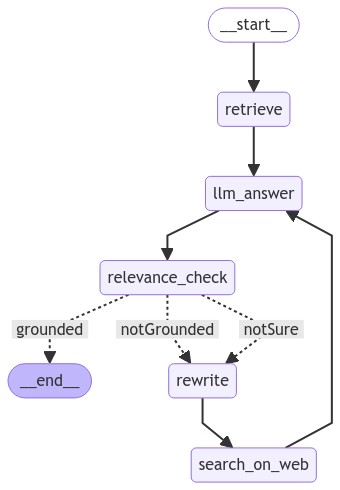

In [17]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [15]:
config = RunnableConfig(
    recursion_limit=12, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
)

In [13]:
list(app.stream({'question':"도로명주소법 시행령 2조의 내용은?"}, config=config))

[(Document(metadata={'source': 'data/final/도로명주소법시행규칙.txt'}, page_content='도로명주소법 시행규칙\n[시행 2022. 3. 30.] [행정안전부령 제324호, 2022. 3. 30., 타법개정]\n행정안전부(주소생활공간과) 044-205-3567\n\n제1조(목적) 이 규칙은 「도로명주소법」 및 같은 법 시행령에서 위임된 사항과 그 시행에 필요한 사항을 규정함을 목적으로 한다.\n\n제2조(정의) 이 규칙에서 사용하는 용어의 뜻은 다음과 같다.\n1. “주된구간”이란 하나의 도로구간에서 종속구간을 제외한 도로구간을 말한다.\n2. “도로명관할구역”이란 「도로명주소법 시행령」(이하 “영”이라 한다) 제6조제1항제1호 및 제2호에 따른 행정구역을 말한다. 다만, 행정구역이 결정되지 않은 지역에서는 영 제6조제2항제1호가목 및 제2호나목에 따른 사업지역의 명칭을 말한다.\n3. “건물등관할구역”이란 영 제6조제1항제1호부터 제3호까지에 따른 행정구역을 말한다. 다만, 행정구역이 결정되지 않은 지역에서는 영 제6조제2항제1호가목 및 제2호나목에 따른 사업지역의 명칭을 말한다.'), 0.7909223437309265), (Document(metadata={'source': 'data/final/도로명주소법시행령.txt'}, page_content='도로명주소법 시행령\n[시행 2024. 5. 28.] [대통령령 제34533호, 2024. 5. 28., 타법개정]\n행정안전부(주소생활공간과) 044-205-3567\n\n제1조(목적) 이 영은 「도로명주소법」에서 위임된 사항과 그 시행에 필요한 사항을 규정함을 목적으로 한다.\n\n제2조(정의) 이 영에서 사용하는 용어의 뜻은 다음과 같다.\n1. “예비도로명”이란 도로명을 새로 부여하려거나 기존의 도로명을 변경하려는 경우에 임시로 정하는 도로명을 말한다.\n2. “유사도로명”이란 특정 도로명을 다른 도로명의 일부로 

GraphRecursionError: Recursion limit of 12 reachedwithout hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

In [10]:
app.invoke({'question':"도로명주소법1조의 내용은?"}, config=config)

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


{'question': '도로명주소법1조의 내용은?',
 'context': [(Document(metadata={'source': 'data/final/도로명주소법시행령.txt'}, page_content='도로명주소법 시행령\n[시행 2024. 5. 28.] [대통령령 제34533호, 2024. 5. 28., 타법개정]\n행정안전부(주소생활공간과) 044-205-3567\n\n제1조(목적) 이 영은 「도로명주소법」에서 위임된 사항과 그 시행에 필요한 사항을 규정함을 목적으로 한다.\n\n제2조(정의) 이 영에서 사용하는 용어의 뜻은 다음과 같다.\n1. “예비도로명”이란 도로명을 새로 부여하려거나 기존의 도로명을 변경하려는 경우에 임시로 정하는 도로명을 말한다.\n2. “유사도로명”이란 특정 도로명을 다른 도로명의 일부로 사용하는 경우 특정 도로명과 다른 도로명 모두를 말한다.\n3. “동일도로명”이란 도로구간이 서로 연결되어 있으면서 그 이름이 같은 도로명을 말한다.\n4. “종속구간”이란 다음 각 목의 어느 하나에 해당하는 구간으로서 별도로 도로구간으로 설정하지 않고 그 구간에 접해 있는 주된 도로구간에 포함시킨 구간을 말한다.\n가. 막다른 구간\n나. 2개의 도로를 연결하는 구간'),
   0.8671318888664246),
  (Document(metadata={'source': 'data/final/도로명주소법.txt'}, page_content='도로명주소법\n[시행 2021. 6. 9.] [법률 제17574호, 2020. 12. 8., 전부개정]\n행정안전부(주소생활공간과) 044-205-3567\n\n제1조(목적) 이 법은 도로명주소, 국가기초구역, 국가지점번호 및 사물주소의 표기ㆍ사용ㆍ관리ㆍ활용 등에 관한 사항을 규정함으로써 국민의 생활안전과 편의를 도모하고 관련 산업의 지원을 통하여 국가경쟁력 강화에 이바지함을 목적으로 한다.'),
   0.8699048757553101)],
 'answer': '

In [11]:
app.invoke({'question':"중앙대학교 문헌정보학과의 교수 수는?"}, config=config)

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


GraphRecursionError: Recursion limit of 12 reachedwithout hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

In [10]:
def stream_responses(question):
    config = RunnableConfig(
        recursion_limit=12, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
    )

    # AgentState 객체를 활용하여 질문을 입력합니다.
    inputs = GraphState(
        question=question
    )

    # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
    try:
        output_generator = app.invoke(inputs, config=config)
        return output_generator
    except GraphRecursionError as e:
        # 예외 발생 시 반환값을 명확히 설정합니다.
        return "해당 질문에 대해서 답변할 수 없습니다."

In [18]:
stream_responses('도로명주소법시행령 3조의 내용은?')

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


'해당 질문에 대해서 답변할 수 없습니다.'

In [12]:
stream_responses('도로명주소법 2조의 내용은?')

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


{'question': '도로명주소법 2조의 내용은?',
 'context': [(Document(metadata={'source': 'data/final/[1018] 주소정보_업무편람_최종(하이퍼링크).docx'}, page_content='제2절 주소정보 개념\n\n\n가. 사전적 의미\n\n1) 국어사전\n\n사람 또는 기업이 살거나 소재하고 있는 곳\n\n사람이 살고 있는 곳이나 기관, 회사 따위가 자리 잡고 있는 곳을 행정구역으로 나타낸 이름\n\n관련 용어\n\n거소(居所) : 얼마간 계속 머물러 있는 장소\n\n가주소(假住所) : 어느 행위에 있어서, 주소 이외의 장소에 주소로서의 법률적 효과를 부여하기 위해 당사자가 선정한 장소\n\n2) 영어사전\n\n사람이나 조직이 연락 가능한 장소(a place where a person or organization may be communicated with)\n\n편지나 소포 등의 겉봉에 있는 배달지(direction for delivery on the outside of an object as a letter or package)\n\n\n\n나. 법률적 의미\n\n1) 민법 : 생활근거지 또는 사업장 소재지를 의미\n\n생활의 근거가 되는 곳(법 §18①)'),
   0.8957435488700867),
  (Document(metadata={'source': 'data/final/[1018] 주소정보_업무편람_최종(하이퍼링크).docx'}, page_content='3) 우편법\n\n우편물은 그 표면에 기재된 곳에 배달함(법 §31)\n\n4) 도로명주소법\n\n“도로명주소”라 함은 도로명, 건물번호 및 상세주소(상세주소가 있는 경우만 해당한다)로 표기하는 주소를 말함(법 §2제7호)\n\n이 법은 주소의 적용에 관한 사항에 있어 다른 법률에 우선함(법 §3)\n\n공법관계의 주소는 도로명주소로 함. 따라서 공공기관은 주소의 표기 및 위치 안내에 있어 도로명주소를 사용해야 함(법 §19)\n\n가.

In [28]:
stream_responses('중앙대학교 문헌정보학과 교수의 수는?')

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


# 서치 테스트

## Google Search 테스트

- https://python.langchain.com/v0.2/docs/integrations/tools/google_search/
- https://eehnuyh.tistory.com/28
- https://gmnithinsai.medium.com/integrate-google-search-to-chat-bot-using-langgraph-bde7b5d21bc6

In [2]:
pip install --upgrade --quiet  langchain langchain-google-vertexai "langchain-google-community[featurestore]"

Note: you may need to restart the kernel to use updated packages.


In [18]:
from typing import Annotated
from typing_extensions import TypedDict
import os
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI

In [22]:
def embeddings(query):
    search = GoogleSearchAPIWrapper()
    result = search.run(query)
    return result


In [23]:
embeddings("도로명주소법1조의 내용은?")

'제1장 총 칙 제1조(목적) 본 약관은 도로명주소 누리집 (이하 "당 사이트")가 제공하는 모든 서비스(이하 "서비스")의 이용조건 및 절차, 이용자와 당 사이트의 권리,\xa0... 제1조(목적) 이 법은 도로명주소, 국가기초구역 및 국가지점번호의 표기ㆍ관리ㆍ활용과 도로명주소의 부여ㆍ사용ㆍ관리 등에 관한 사항을 규정함으로써 국민의 생활\xa0... 제1장 총 칙 - 제1조(목적) 본 약관은 도로명주소 누리집 (이하 "당사이트")가 제공하는 모든 서비스(이하 "서비스")의 이용조건 및 절차, 이용자와 당 사이트의 권리,\xa0... ... 내용을 제21조제1항에 따라 고시하여야 한다. ⑥ 시장등은 제7조의2제1항 전단 또는 제7조의3제1항에 따른 신청을 받아 시ㆍ도지사에게 법 제8조제2항에 따른 신청을\xa0... Family Relations, Addenda: Article 3, Section 1. 등록기준지. Place of Registration. 경정사유: 도로명주소법 제20조. Amendment Reason: Road Name Address Act\xa0... Mar 30, 2022 ... 제30조(총괄대장 및 개별대장의 내용) ① 총괄대장은 다음 각 호의 내용을 포함해야 한다. 1. 도로명관할구역 및 도로명. 2. 도로구간의 시작지점 및 끝\xa0... In accordance to the Family Registry Law Addendum: Article 3, Section 1. 가족관계증명서. Certificate of Family Registry. 경정사유: 도로명주소법 제20조. Feb 24, 2011 ... 제1조(목적) 이 지침은 도로명주소법 시행령 제23조제6항에 따라 도로명주소를 보다 효율적으로 소유자·점유자에게 알리기 위하여 전국적으로 동시에\xa0... ① 시장등은 도로명주소시설의 효율적인 유지관리를 위하여 대통령령으로 정하는 바에 따라 그 시설의 유지관리를 위탁할 수 있다. ② 시장등은 연 1회 이상 도로명주소\xa0... 제6

In [19]:
search = GoogleSearchAPIWrapper()


def top5_results(query):
    return search.results(query, 1)


tool = Tool(
    name="Google Search Snippets",
    description="Search Google for recent results.",
    func=top5_results,
)

In [21]:
result = tool.run('도로명주소법 시행규칙 1조의 내용은?')
result

[{'title': '도로명 주소',
  'link': 'https://www.juso.go.kr/addrlink/tchnlgySport/personalDataAgree.do',
  'snippet': '제1조(목적) 본 약관은 도로명주소 누리집 (이하 "당 사이트")가 제공하는 ... 법 시행규칙 제53조제1항 - 보유기간 : 서비스 이용기간 종료 후 3년까지 ※ 개인\xa0...'}]

In [8]:
result[0]['link']

'https://ko.wikipedia.org/wiki/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD%EC%9D%98_%EB%8C%80%ED%86%B5%EB%A0%B9_%EB%AA%A9%EB%A1%9D'

In [17]:
list(result)[0]['link']

'https://ko.wikipedia.org/wiki/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD%EC%9D%98_%EB%8C%80%ED%86%B5%EB%A0%B9_%EB%AA%A9%EB%A1%9D'

In [9]:
result[0]['link']

'https://ko.wikipedia.org/wiki/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD%EC%9D%98_%EB%8C%80%ED%86%B5%EB%A0%B9_%EB%AA%A9%EB%A1%9D'

In [15]:
def search_tool(query):
    search = GoogleSearchAPIWrapper()
    return search.results(query, 1)

tool = Tool(
    name="Google Search Snippets",
    description="Search Google for recent results.",
    func=search_tool,
)

def search_on_web(query):
    result = tool.run(query)
    return result

search_on_web('대한민국의 대통령 이름은?')

[{'title': '대한민국의 대통령 목록 - 위키백과, 우리 모두의 백과사전',
  'link': 'https://ko.wikipedia.org/wiki/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD%EC%9D%98_%EB%8C%80%ED%86%B5%EB%A0%B9_%EB%AA%A9%EB%A1%9D',
  'snippet': '대한민국의 대통령 목록은 대한민국의 대통령의 명단이다. 헌법에 따라 현행 대통령 임기는 5년 단임제이다. 목차. 1 역대 대통령 목록; 2 시계열; 3 생존 중인 전직\xa0...'}]

## TabilySearch 테스트

In [2]:
pip install -qU langchain-community tavily-python

Note: you may need to restart the kernel to use updated packages.


In [1]:
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
import os

load_dotenv()

def search_on_web(query):
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    search_tool = TavilySearchResults(max_results=1)
    search_result = search_tool.invoke({"query": query})
    return search_result

In [3]:
result = search_on_web('What happened in the latest burning man floods')
result

[{'url': 'https://www.cnn.com/2023/09/05/us/burning-man-storms-shelter-exodus-tuesday/index.html',
  'content': "CNN values your feedback\nBurning Man attendees make a mass exodus after a dramatic weekend that left thousands stuck in the Nevada desert\nThousands of Burning Man attendees finally made their mass exodus after intense rain over the weekend flooded camp sites and filled them with thick, ankle-deep mud – stranding more than 70,000 free-spirited revelers as they waited for the Nevada desert city to dry out.\n Burning Man organizers lift driving ban after heavy rains left the event smothered in mud and trapped thousands\nThe area was still muddy and parts were still difficult to navigate, organizers warned, and the wait time to leave the city Monday night was about seven hours. Diplo hitchhiked ride out of rain-drenched Burning Man after walking miles 'through the mud' and actually made it to his DC concert\n“Quite a wet start to September for much of eastern CA-western NV,” t

In [49]:
print(result[0]['content'])

1. "도로명주소"란 이 법에 따라 부여된 도로명, 건물번호 및 상세주소(상세주소가 있는 경우만 해당한다)에 의하여 표기하는 주소를 말한다. 2. "건물등"이란 「건축법」 제2조제1항제2호에 따른 건축물과 현실적으로 30일 이상 거주나 정착된 활동에 이용 되는 ...


In [38]:
search_on_web('도로명주소법 3조의 내용은?')

[{'url': 'https://casenote.kr/법령/도로명주소법/',
  'content': '③ 제1항 및 제2항에 따른 지원의 세부 내용은 대통령령으로 정한다. ... 제7조의3제5항 중 "「도로명주소법」 제2조제5호에 따른 도로명 및 같은 조 제7호에 따른 건물번호"를 "「도로명주소법」 제2조제3호에 따른 도로명 및 같은 조 제5호에 따른 건물번호"로 한다 ...'},
 {'url': 'http://www.yeslaw.co.kr/lims/front/page/fulltext.html?pAct=view&pPromulgationNo=149050',
  'content': '도로명주소법. 제1조 (목적) 이 법은 도로명 및 건물번호에 의한 주소표기에 따른 관련 시설의 설치·유지관리·활용과 도로명주소의 부여·사용·관리 등에 관한 사항을 규정하여 국민의 생활편의를 도모하고 물류비 절감 등 국가경쟁력 강화에 기여함을 ...'},
 {'url': 'http://www.yeslaw.kr/lims/front/page/fulltext.html?pAct=view&pPromulgationNo=183001',
  'content': '도로명주소법. 제1조 (목적) 이 법은 도로명주소, 국가기초구역 및 국가지점번호의 표기ㆍ관리ㆍ활용과 도로명주소의 부여ㆍ사용ㆍ관리 등에 관한 사항을 규정함으로써 국민의 생활안전과 편의를 도모하고 물류비 절감 등 국가경쟁력 강화에 이바지함을 ...'},
 {'url': 'http://www.yeslaw.com/lims/front/page/fulltext.html?action=LAW&lawid=4207&jo_s=000806&jo_e=',
  'content': '도로명주소법. (시행일자 : 2021-06-09) - 전부개정 -. 제8조 (도로명 등의 변경 및 폐지) ① 행정안전부장관, 시ㆍ도지사 및 시장ㆍ군수ㆍ구청장은 제2항에 따른 신청을 받거나 제3항에 따른 요청을 받은 경우, 그 밖에 도로명주소 관리를 위하여 필요하다고 인정하는 ...'},
 

In [39]:
search_on_web('도로명주소법 시행규칙 3조의 내용은?')

[{'url': 'http://www.yeslaw.kr/lims/front/page/fulltext.html?pAct=view&pPromulgationNo=149502',
  'content': '도로명주소법 시행규칙. 제1조 (목적) 이 규칙은 「도로명주소법」 및 같은 법 시행령 에서 위임된 사항과 그 시행에 필요한 사항을 규정함을 목적으로 한다. [전문개정 2009·8·14] ① 「도로명주소법 시행령」 (이하 "영"이라 한다) 제3조제1항제5호 의 건물번호는 ...'},
 {'url': 'https://law.go.kr/LSW/lsRvsDocListP.do?lsId=010421&chrClsCd=010202&lsRvsGubun=all',
  'content': '제3조(「도로명주소법 시행규칙」의 개정) 도로명주소법 시행규칙 일부를 다음과 같이 개정한다. ... 이 경우 「도로명주소법」 제8조의3제3항에 따라 행정안전부장관이 작성ㆍ보급한 도로명관리시스템으로 전자적 처리가 가능한 대장은 전자적인 형태로 ...'},
 {'url': 'https://www.ulex.co.kr/법률/95941-010421-도로명주소법 시행규칙',
  'content': '도로명주소법 시행규칙. 제1조 (목적) 이 규칙은 「 도로명주소법 」 및 같은 법 시행령 에서 위임된 사항과 그 시행에 필요한 사항을 규정함을 목적으로 한다. ① 「 도로명주소법 시행령 」 (이하 "영"이라 한다) 제3조 제1항 제5호 의 건물번호는 \'번\'으로 읽되 ...'},
 {'url': 'https://m.gwangjin.go.kr/portal/cmmn/file/fileDown.do?menuNo=200992&atchFileId=cd6beff6b4f4e23cf3ba8f107724ecb7bb4fbbdef79331a84d09922ae2d5099a&fileSn=3',
  'content': '도로명주소법 시행규칙 도로명주소법 시행규칙 [시행 2017. 7. 26.] [행정안전부령 제1호, 2017. 7. 26.,

## DuckDuckGoSearch 테스트

* 일반: price는 잘 모르겠는데 한달에 100건 제한이 있는듯
* parameter 설명 참고: https://pypi.org/project/duckduckgo-search/#regions

In [25]:
pip install -qU duckduckgo-search langchain-community

Note: you may need to restart the kernel to use updated packages.


In [26]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuck GoSearchRun()

search.invoke("Obama's first name?")

"Barack Obama—with his wife, Michelle—being sworn in as the 44th president of the United States, January 20, 2009. Key events in the life of Barack Obama. Barack Obama (born August 4, 1961, Honolulu, Hawaii, U.S.) is the 44th president of the United States (2009-17) and the first African American to hold the office. As the head of the government of the United States, the president is arguably the most powerful government official in the world. The president is elected to a four-year term via an electoral college system. Since the Twenty-second Amendment was adopted in 1951, the American presidency has been Obama was born on August 4, 1961, [1] at Kapi ʻ olani Maternity & Gynecological Hospital (now Kapi ʻ olani Medical Center for Women and Children) in Honolulu, Hawaii, [2] [3] [4] and would become the first President to have been born in Hawaii. [5] His mother, Stanley Ann Dunham, was born in Wichita, Kansas, and was of mostly English ancestry. [6] His father, Barack Obama, Sr., was a

In [27]:
from langchain_community.tools import DuckDuckGoSearchResults

search = DuckDuckGoSearchResults()

search.invoke("Obama")

'[snippet: Former President Barack Obama and former first lady Michelle Obama endorsed Vice President Kamala Harris\' presidential bid in a video released Friday. "Michelle and I couldn\'t be prouder to ..., title: Barack and Michelle Obama endorse Kamala Harris for president, link: https://www.cnn.com/2024/07/26/politics/barack-michelle-obama-kamala-harris-endorsement/index.html], [snippet: Learn about the life and achievements of Barack Obama, the 44th president of the United States and the first African American to hold the office. Explore his early years, education, political career, books, awards, and more., title: Barack Obama | Biography, Parents, Education, Presidency, Books ..., link: https://www.britannica.com/biography/Barack-Obama], [snippet: The endorsements of former President Barack Obama and Michelle Obama cap a week where the Democratic party, for the most part, lined up behind Vice President Harris to become their nominee., title: The Obamas endorse Kamala Harris for 

In [35]:
result = search.invoke("도로명주소법 3조의 내용은?")
print(result)

[snippet: 제3조(도로의 유형 및 통로의 종류) ① 「도로명주소법」(이하 "법"이라 한다) 제2조제1호에 따른 도로는 유형별로 다음 각 호와 같이 구분한다. 1. 지상도로: 주변 지대(地帶)와 높낮이가 비슷한 도로(제2호의 입체도로가 지상도로의 일부에 연속되는 경우를 포함한다)로서 다음 각 목의 도로, title: 도로명주소법 시행령 - CaseNote - 케이스노트, link: https://casenote.kr/법령/도로명주소법_시행령/], [snippet: 본문 제정·개정이유 별표·서식 연혁 3단비교 신구법비교 법령체계도 법령비교 생활법령정보 조례위임조문 위임조례 한눈보기 원문다운로드 조문 선택 조문선택 화면내검색 새창 선택, title: 도로명주소법 시행령 | 국가법령정보센터 | 법령 > 본문, link: https://law.go.kr/LSW/lsInfoP.do?lsiSeq=262811], [snippet: 제3조(도로의 유형 및 통로의 종류) ① 「도로명주소법」(이하 "법"이라 한다) 제2조 제1호에 따른 도로는 유형별로 다음 각 호와 같이 구분한다. 1. 지상도로: 주변 지대(地帶)와 높낮이가 비슷한 도로(제2호의 입체도로가 지상도로의 일부에 연속되는 경우를 포함한다)로서 다음 각 목의 도로, title: 국가법령정보센터 | 조문정보, link: https://law.go.kr/lsLinkCommonInfo.do?lsJoLnkSeq=1022032683&chrClsCd=010202&ancYnChk=], [snippet: ③ 제1항 및 제2항에 따른 지원의 세부 내용은 대통령령으로 정한다. _ ... 제7조의3제5항 중 "「도로명주소법」 제2조제5호에 따른 도로명 및 같은 조 제7호에 따른 건물번호"를 "「도로명주소법」 제2조제3호에 따른 도로명 및 같은 조 제5호에 따른 건물번호"로 한다., title: 법령 - 도로명주소법 - 로앤비, link: https://www.lawnb.com/Info/ContentView?sid=L000010300

In [36]:
resultresult = search.invoke("도로명주소법 시행령 3조의 내용은?")
print(result)

[snippet: 제3조(도로의 유형 및 통로의 종류) ① 「도로명주소법」(이하 "법"이라 한다) 제2조제1호에 따른 도로는 유형별로 다음 각 호와 같이 구분한다. 1. 지상도로: 주변 지대(地帶)와 높낮이가 비슷한 도로(제2호의 입체도로가 지상도로의 일부에 연속되는 경우를 포함한다)로서 다음 각 목의 도로, title: 도로명주소법 시행령 - CaseNote - 케이스노트, link: https://casenote.kr/법령/도로명주소법_시행령/], [snippet: 본문 제정·개정이유 별표·서식 연혁 3단비교 신구법비교 법령체계도 법령비교 생활법령정보 조례위임조문 위임조례 한눈보기 원문다운로드 조문 선택 조문선택 화면내검색 새창 선택, title: 도로명주소법 시행령 | 국가법령정보센터 | 법령 > 본문, link: https://law.go.kr/LSW/lsInfoP.do?lsiSeq=262811], [snippet: 제3조(도로의 유형 및 통로의 종류) ① 「도로명주소법」(이하 "법"이라 한다) 제2조 제1호에 따른 도로는 유형별로 다음 각 호와 같이 구분한다. 1. 지상도로: 주변 지대(地帶)와 높낮이가 비슷한 도로(제2호의 입체도로가 지상도로의 일부에 연속되는 경우를 포함한다)로서 다음 각 목의 도로, title: 국가법령정보센터 | 조문정보, link: https://law.go.kr/lsLinkCommonInfo.do?lsJoLnkSeq=1022032683&chrClsCd=010202&ancYnChk=], [snippet: ③ 제1항 및 제2항에 따른 지원의 세부 내용은 대통령령으로 정한다. _ ... 제7조의3제5항 중 "「도로명주소법」 제2조제5호에 따른 도로명 및 같은 조 제7호에 따른 건물번호"를 "「도로명주소법」 제2조제3호에 따른 도로명 및 같은 조 제5호에 따른 건물번호"로 한다., title: 법령 - 도로명주소법 - 로앤비, link: https://www.lawnb.com/Info/ContentView?sid=L000010300

In [40]:
search.invoke("중앙대학교 문헌정보학과의 교수 수는?")

'[snippet: 교육과정(2023) 교육과정(2022) 교육과정(2021) 교육과정(2020) 교육과정(2019) 교육과정(2018), title: 교수소개 - 문헌정보학과, link: https://www.kyonggi.ac.kr/u_library/contents.do?key=6688], [snippet: - 문헌 정보학과 4년제 대학-*서울. 연세대학교 문헌정보학과. 서울여자 대학교 문헌정보학과. 숙명여자 대학교 문헌정보학과. 이화여자 대학교 문헌정보학과. 중앙 대학교 문헌정보학과. 동덕여자대학교 사회과학부 문헌정보학전공. 상명대학교 인문콘텐츠학부 문헌정보학전공, title: 문헌정보학과 4년제 전국대학 모음, link: https://youmanbo.tistory.com/152], [snippet: 06974 서울시 동작구 흑석로 84 중앙대학교 사회과학대학 문헌정보학과 203동 514호. 전화 : 학과사무실 02-820-5144 / 팩스 : 02-816-5146 / E-mail : sust028@cau.ac.kr., title: 중앙대학교 문헌정보학과, link: https://lis.cau.ac.kr/02_notice/notice_04a.php], [snippet: 내신이 4등급 중반인데 수능 최저 없는 문헌정보학과 대학 알려주세요!, title: 문헌정보학과 대학교 : 지식iN - 네이버 지식iN, link: https://kin.naver.com/qna/detail.naver?d1id=11&dirId=11050401&docId=453213459]'

In [52]:
from langchain_community.tools import DuckDuckGoSearchResults

search = DuckDuckGoSearchResults()
result = search.invoke("도로명주소법 3조의 내용은?")
result

'[snippet: 제3조(도로의 유형 및 통로의 종류) ① 「도로명주소법」(이하 "법"이라 한다) 제2조제1호에 따른 도로는 유형별로 다음 각 호와 같이 구분한다. 1. 지상도로: 주변 지대(地帶)와 높낮이가 비슷한 도로(제2호의 입체도로가 지상도로의 일부에 연속되는 경우를 포함한다)로서 다음 각 목의 도로, title: 도로명주소법 시행령 - CaseNote | 케이스노트, link: https://casenote.kr/법령/도로명주소법_시행령/], [snippet: 본문 제정·개정이유 별표·서식 연혁 3단비교 신구법비교 법령체계도 법령비교 생활법령정보 조례위임조문 위임조례 한눈보기 원문다운로드 조문 선택 조문선택 화면내검색 새창 선택, title: 도로명주소법 시행령 | 국가법령정보센터 | 법령 > 본문, link: https://law.go.kr/LSW/lsInfoP.do?lsiSeq=262811], [snippet: 제3조(도로의 유형 및 통로의 종류) ① 「도로명주소법」(이하 "법"이라 한다) 제2조 제1호에 따른 도로는 유형별로 다음 각 호와 같이 구분한다. 1. 지상도로: 주변 지대(地帶)와 높낮이가 비슷한 도로(제2호의 입체도로가 지상도로의 일부에 연속되는 경우를 포함한다)로서 다음 각 목의 도로, title: 국가법령정보센터 | 조문정보, link: https://law.go.kr/lsLinkCommonInfo.do?lsJoLnkSeq=1022032683&chrClsCd=010202&ancYnChk=], [snippet: ③ 제1항 및 제2항에 따른 지원의 세부 내용은 대통령령으로 정한다. _ ... 제7조의3제5항 중 "「도로명주소법」 제2조제5호에 따른 도로명 및 같은 조 제7호에 따른 건물번호"를 "「도로명주소법」 제2조제3호에 따른 도로명 및 같은 조 제5호에 따른 건물번호"로 한다., title: 법령 - 도로명주소법 | 로앤비, link: https://www.lawnb.com/Info/ContentView?sid=L00001030

In [3]:
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults

wrapper = DuckDuckGoSearchAPIWrapper(region="kr-kr", time="d", max_results=2)

search = DuckDuckGoSearchResults(api_wrapper=wrapper, source="text")

search.invoke("건축물대장에 대해서 알려줘")

'[snippet: 2018년 이후 최고치 찍음그때야 남북미 회담으로 분위기가 좋아서 그랬다지만 지금은 최악에 가까운데도 이례적으로 높아졌고 심지어 작년에 같은 기관 조사에선 64%가 찍혔는데 몇달만에 수직상승한 셈이유는 단순한듯하다풍선이고 뭐고 이젠 지겨워죽겠다어차피 이러니저러니 북한때문에 손해 ..., title: 최근 통일 찬성여론이 급격히 올라간 이유 | 유머 게시판 | Ruliweb, link: https://m.ruliweb.com/community/board/300143/read/67085530], [snippet: 본 공사를 도급받은 건설사업자는 「건설산업기본법」 제22조제4항 및 제6항에 따라 건설공사에 관한 사항을 건설공사대장에 적고, 건설산업종합정보망 을 이용 하여 도급계약을 체결한 날부터 30 일 이내 에 발주자에게 통보하여야 하고, 통보한 사항에 변경 이 ..., title: 국도13호선 강진 송월지구 등 2개소 사고잦은곳 개선공사 (긴급공고) - 낙찰 잘되는 전기넷, link: https://www.jungi.net/detail_bid/index/bid8655408]'